In [195]:
import tensorflow as tf
from tqdm import tqdm
import copy
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
import pickle
import sys

In [196]:
clients = [0 , 1, 2]
epochs = 20

In [197]:
import tensorflow as tf
import numpy as np

# Load the MNIST dataset
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train_all = x_train_all.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [198]:
# Define the model architecture
def create_model():
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(28, 28, 1)
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model


# # Define the MAML model
# class MAML(tf.keras.Model):
#     def __init__(self, model):
#         super(MAML, self).__init__()
#         self.model = model

#     def train_step(self, data):
#         x, y = data
#         x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
#         y = tf.reshape(y, (-1,))  # Reshape the target labels
#         with tf.GradientTape() as tape:
#             y_pred = self.model(x)
#             loss = self.compiled_loss(y, y_pred)
#         gradients = tape.gradient(loss, self.model.trainable_variables)
#         self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
#         self.compiled_metrics.update_state(y, y_pred)
#         return {m.name: m.result() for m in self.metrics}

#     def test_step(self, data):
#         x, y = data
#         x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
#         y = tf.reshape(y, (-1,))  # Reshape the target labels
#         y_pred = self.model(x)
#         self.compiled_loss(y, y_pred)
#         self.compiled_metrics.update_state(y, y_pred)
#         return {m.name: m.result() for m in self.metrics}


class MAML(tf.keras.Model):
    def __init__(self, model):
        super(MAML, self).__init__()
        self.model = model

    def call(self, inputs):
        x = tf.reshape(inputs, (-1, 28, 28, 1))  # Reshape the input tensor
        return self.model(x)

    def get_config(self):
        return {"model": self.model.get_config()}

    @classmethod
    def from_config(cls, config):
        model = tf.keras.models.Model.from_config(config["model"])
        return cls(model)

    def train_step(self, data):
        x, y = data
        x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
        y = tf.reshape(y, (-1,))  # Reshape the target labels
        with tf.GradientTape() as tape:
            y_pred = self.model(x)
            loss = self.compiled_loss(y, y_pred)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
        y = tf.reshape(y, (-1,))  # Reshape the target labels
        y_pred = self.model(x)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}


# Define the meta-learning parameters
num_meta_updates = 10
num_inner_updates = 5
meta_batch_size = 32
inner_batch_size = 10

In [199]:
from sklearn.model_selection import train_test_split

# assume X is your feature data and y is your target data
X_train, x_test, y_train, y_test = train_test_split(
    x_train_all, y_train_all, test_size=0.2, random_state=42
)

# split data into n parts
n_parts = len(clients)
part_size = len(X_train) // n_parts
dataset_parts = []
for i in range(n_parts):
    start = i * part_size
    end = (i + 1) * part_size
    X_part = X_train[start:end]
    y_part = y_train[start:end]
    dataset_parts.append((X_part, y_part))

In [200]:
a = dataset_parts
x , y = a[2]
len(x) , len(y)

(16000, 16000)

In [201]:
def model_init():
    model = MAML(create_model())
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model

In [202]:
models = []
for _ in range(len(clients)):
    models.append(model_init())

In [203]:
import numpy as np
from Pyfhel import Pyfhel

HE = Pyfhel() 
ckks_params = {
    "scheme": "CKKS", 
    "n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
    "scale": 2**30,  # All the encodings will use it for float->fixed point
    "qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
}
HE.contextGen(**ckks_params)  # Generate context for ckks scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()
HE.relinKeyGen()

In [204]:
shapedims = [l.shape for l in models[0].get_weights()]
print(shapedims)

[(3, 3, 1, 32), (32,), (3, 3, 32, 64), (64,), (3, 3, 64, 64), (64,), (576, 64), (64,), (64, 10), (10,)]


In [205]:
def generate_diffie_hellman_parameters():
    parameters = dh.generate_parameters(generator=2, key_size=512)
    return parameters


def generate_diffie_hellman_keys(parameters):
    private_key = parameters.generate_private_key()
    public_key = private_key.public_key()
    return private_key, public_key


def derive_key(private_key, peer_public_key):
    shared_key = private_key.exchange(peer_public_key)
    derived_key = HKDF(
        algorithm=hashes.SHA256(),
        length=32,
        salt=None,
        info=b"handshake data",
    ).derive(shared_key)
    return derived_key


def encrypt_message_AES(key, message):
    serialized_obj = pickle.dumps(message)
    cipher = Cipher(algorithms.AES(key), modes.ECB())
    encryptor = cipher.encryptor()
    padded_obj = serialized_obj + b" " * (16 - len(serialized_obj) % 16)
    ciphertext = encryptor.update(padded_obj) + encryptor.finalize()
    return ciphertext


def decrypt_message_AES(key, ciphertext):
    cipher = Cipher(algorithms.AES(key), modes.ECB())
    decryptor = cipher.decryptor()
    padded_obj = decryptor.update(ciphertext) + decryptor.finalize()
    serialized_obj = padded_obj.rstrip(b" ")
    obj = pickle.loads(serialized_obj)
    return obj


def setup_AES():
    num_clients = len(clients)
    parameters = generate_diffie_hellman_parameters()
    server_private_key, server_public_key = generate_diffie_hellman_keys(parameters)
    client_keys = [generate_diffie_hellman_keys(parameters) for _ in range(num_clients)]
    shared_keys = [
        derive_key(server_private_key, client_public_key)
        for _, client_public_key in client_keys
    ]
    client_shared_keys = [
        derive_key(client_private_key, server_public_key)
        for client_private_key, _ in client_keys
    ]

    return client_keys, shared_keys , client_shared_keys

In [206]:
client_keys, shared_keys, client_shared_keys = setup_AES()

In [207]:
def encrypt_wt(wtarray , i):
    cwt = []
    for layer in wtarray:
        flat_array = layer.astype(np.float64).flatten()

        chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
        clayer = []
        for chunk in chunks:
            ptxt = HE.encodeFrac(chunk)
            ctxt = HE.encryptPtxt(ptxt)
            clayer.append(ctxt)
        cwt.append(clayer.copy())
    ciphertext = encrypt_message_AES(client_shared_keys[i], cwt)
    return ciphertext

In [208]:
def aggregate_wt(encypted_cwts):
    cwts = []
    for i , ecwt in enumerate(encypted_cwts):
        cwts.append(decrypt_message_AES(shared_keys[i], ecwt))
    resmodel = []
    for j in range(len(cwts[0])):  # for layers
        layer = []
        for k in range(len(cwts[0][j])):  # for chunks
            tmp = cwts[0][j][k].copy()
            for i in range(1, len(cwts)):  # for clients
                tmp = tmp + cwts[i][j][k]
            tmp = tmp / len(cwts)
            layer.append(tmp)
        resmodel.append(layer)

    res = [resmodel.copy() for _ in range(len(clients))]
    return res
    

In [209]:
def decrypt_weights(res):
    decrypted_weights = []
    for client_weights, model in zip(res, models):
        decrypted_client_weights = []
        wtarray = model.get_weights()
        for layer_weights, layer in zip(client_weights, wtarray):
            decrypted_layer_weights = []
            flat_array = layer.astype(np.float64).flatten()
            chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
            for chunk, encrypted_chunk in zip(chunks, layer_weights):
                decrypted_chunk = HE.decryptFrac(encrypted_chunk)
                original_chunk_size = len(chunk)
                decrypted_chunk = decrypted_chunk[:original_chunk_size]
                decrypted_layer_weights.append(decrypted_chunk)
            decrypted_layer_weights = np.concatenate(decrypted_layer_weights, axis=0)
            decrypted_layer_weights = decrypted_layer_weights.reshape(layer.shape)
            decrypted_client_weights.append(decrypted_layer_weights)
        decrypted_weights.append(decrypted_client_weights)
    return decrypted_weights

In [210]:
accuracies = [[] for _ in range(len(clients))]
losses = [[] for _ in range(len(clients))]

In [211]:
# def train_model(model, x_train, y_train):
#     meta_updates = []
#     accuracy_over_time = []
#     for meta_update in range(num_meta_updates):
#         # Sample a meta-batch of tasks
#         meta_batch = tf.random.shuffle(tf.range(len(x_train)))[:meta_batch_size]

#         # Inner loop updates for each task
#         for task in meta_batch:
#             task_data = (
#                 x_train[task : task + inner_batch_size],
#                 y_train[task : task + inner_batch_size],
#             )
            
#             for inner_update in range(num_inner_updates):
#                 model.train_step(task_data)

#         # Evaluate on the meta-test set
#         _, accuracy = model.evaluate(x_test, y_test)

#         # Store the meta-update step and accuracy
#         meta_updates.append(meta_update + 1)
#         accuracy_over_time.append(accuracy)
#     avg_accuracy = sum(accuracy_over_time) / len(accuracy_over_time)
#     return model , avg_accuracy

In [212]:
meta_batch_size = 32  # Number of tasks per meta-update
inner_batch_size = 5  # Number of examples per task
num_inner_updates = 1  # Number of inner loop updates per task
num_meta_updates = 1
optimizer = tf.keras.optimizers.legacy.Adam()

In [213]:
def train_model(model, x_train, y_train):
    meta_updates = []
    accuracy_over_time = []
    for meta_update in range(num_meta_updates):
        # Sample a meta-batch of tasks
        meta_batch = tf.random.shuffle(tf.range(len(x_train)))[:meta_batch_size]

        # Inner loop updates for each task
        task_gradients = []
        for task in meta_batch:
            task_data = (
                x_train[task : task + inner_batch_size],
                y_train[task : task + inner_batch_size],
            )

            with tf.GradientTape() as outer_tape:
                with tf.GradientTape() as inner_tape:
                    # Forward pass on the task-specific data
                    predictions = model(task_data[0])
                    loss = tf.keras.losses.sparse_categorical_crossentropy(
                        task_data[1], predictions
                    )

                # Compute gradients for inner loop update
                inner_gradients = inner_tape.gradient(loss, model.trainable_variables)

                # Apply inner loop update to the model's variables
                inner_model = MAML(create_model())
                inner_model.set_weights(model.get_weights())
                optimizer.apply_gradients(
                    zip(inner_gradients, inner_model.trainable_variables)
                )

                # Forward pass with the updated model
                updated_predictions = inner_model(task_data[0])
                updated_loss = tf.keras.losses.sparse_categorical_crossentropy(
                    task_data[1], updated_predictions
                )

            # Compute gradients for outer loop update
            outer_gradients = outer_tape.gradient(
                updated_loss, model.trainable_variables
            )
            task_gradients.append(outer_gradients)

        # Filter out None gradients
        filtered_task_gradients = [
            [grad for grad in task_grad if grad is not None]
            for task_grad in task_gradients
        ]

        # Compute average gradients across tasks
        avg_gradients = [
            tf.reduce_mean(grad_list, axis=0)
            for grad_list in zip(*filtered_task_gradients)
        ]

        # Apply outer loop update to the model's variables
        optimizer.apply_gradients(zip(avg_gradients, model.trainable_variables))

        # Evaluate on the meta-test set
        _, accuracy = model.evaluate(x_test, y_test)

        # Store the meta-update step and accuracy
        meta_updates.append(meta_update + 1)
        accuracy_over_time.append(accuracy)

    avg_accuracy = sum(accuracy_over_time) / len(accuracy_over_time)
    return model, avg_accuracy

In [214]:
def train_model(model, x_train, y_train):
    history = model.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=1,
        verbose=1,
        validation_data=(x_test, y_test),
    )
    avg_accuracy = history.history["val_accuracy"][-1]
    return model, avg_accuracy

In [215]:
cwts = [encrypt_wt(model.get_weights() , i) for i , model in enumerate(models)]
for e in tqdm(range(epochs)):
    cwts = aggregate_wt(cwts)
    wts = decrypt_weights(cwts)
    setup_AES()
    cwts = []
    for wt,model , dataset , i , in zip(wts, models, dataset_parts , range(len(clients))):
        model.set_weights(wt)
        model, accuracy = train_model(model, dataset[0], dataset[1])
        # history = model.fit(dataset[0], dataset[1], epochs=1,  verbose=1)
        # print(history.history["accuracy"][0], history.history["loss"][0])
        # accuracies[i ].append(history.history["accuracy"][0])
        # losses[i].append(history.history["loss"][0])
        accuracies.append(accuracy)
        print("accuracies" , accuracy)
        wtarray = model.get_weights()
        cwts.append(encrypt_wt(wtarray , i))


  0%|                                                                                                                                                     | 0/20 [00:00<?, ?it/s]

250/250 [==============================] - 2s 9ms/step - loss: 0.5448 - accuracy: 0.8243 - val_loss: 0.1937 - val_accuracy: 0.9402
accuracies 0.9401666522026062
250/250 [==============================] - 2s 8ms/step - loss: 0.5408 - accuracy: 0.8347 - val_loss: 0.1779 - val_accuracy: 0.9452
accuracies 0.9452499747276306
250/250 [==============================] - 2s 8ms/step - loss: 0.5648 - accuracy: 0.8226 - val_loss: 0.2407 - val_accuracy: 0.9287
accuracies 0.9287499785423279


  5%|███████                                                                                                                                      | 1/20 [00:12<03:51, 12.19s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.1629 - accuracy: 0.9498 - val_loss: 0.1190 - val_accuracy: 0.9639
accuracies 0.9639166593551636
250/250 [==============================] - 2s 8ms/step - loss: 0.1613 - accuracy: 0.9516 - val_loss: 0.1031 - val_accuracy: 0.9695
accuracies 0.9695000052452087
250/250 [==============================] - 2s 8ms/step - loss: 0.1550 - accuracy: 0.9523 - val_loss: 0.1223 - val_accuracy: 0.9621
accuracies 0.9620833396911621


 10%|██████████████                                                                                                                               | 2/20 [00:23<03:32, 11.81s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0982 - accuracy: 0.9686 - val_loss: 0.0869 - val_accuracy: 0.9728
accuracies 0.9727500081062317
250/250 [==============================] - 2s 8ms/step - loss: 0.0998 - accuracy: 0.9696 - val_loss: 0.0756 - val_accuracy: 0.9759
accuracies 0.9759166836738586
250/250 [==============================] - 2s 8ms/step - loss: 0.0944 - accuracy: 0.9703 - val_loss: 0.0902 - val_accuracy: 0.9731
accuracies 0.9730833172798157


 15%|█████████████████████▏                                                                                                                       | 3/20 [00:35<03:17, 11.64s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0719 - accuracy: 0.9778 - val_loss: 0.0631 - val_accuracy: 0.9811
accuracies 0.981083333492279
250/250 [==============================] - 2s 8ms/step - loss: 0.0766 - accuracy: 0.9765 - val_loss: 0.0735 - val_accuracy: 0.9775
accuracies 0.9775000214576721
250/250 [==============================] - 2s 8ms/step - loss: 0.0693 - accuracy: 0.9779 - val_loss: 0.0898 - val_accuracy: 0.9711
accuracies 0.9710833430290222


 20%|████████████████████████████▏                                                                                                                | 4/20 [00:46<03:05, 11.59s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0599 - accuracy: 0.9827 - val_loss: 0.0681 - val_accuracy: 0.9783
accuracies 0.9782500267028809
250/250 [==============================] - 2s 8ms/step - loss: 0.0638 - accuracy: 0.9811 - val_loss: 0.0631 - val_accuracy: 0.9802
accuracies 0.9801666736602783
250/250 [==============================] - 2s 8ms/step - loss: 0.0564 - accuracy: 0.9818 - val_loss: 0.0618 - val_accuracy: 0.9812
accuracies 0.981166660785675


 25%|███████████████████████████████████▎                                                                                                         | 5/20 [00:58<02:54, 11.61s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0507 - accuracy: 0.9856 - val_loss: 0.0569 - val_accuracy: 0.9827
accuracies 0.9826666712760925
250/250 [==============================] - 2s 8ms/step - loss: 0.0574 - accuracy: 0.9821 - val_loss: 0.0523 - val_accuracy: 0.9834
accuracies 0.9834166765213013
250/250 [==============================] - 2s 8ms/step - loss: 0.0473 - accuracy: 0.9850 - val_loss: 0.0565 - val_accuracy: 0.9840
accuracies 0.984000027179718


 30%|██████████████████████████████████████████▎                                                                                                  | 6/20 [01:10<02:43, 11.68s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0455 - accuracy: 0.9846 - val_loss: 0.0518 - val_accuracy: 0.9845
accuracies 0.984499990940094
250/250 [==============================] - 2s 8ms/step - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.0706 - val_accuracy: 0.9783
accuracies 0.9782500267028809
250/250 [==============================] - 2s 8ms/step - loss: 0.0394 - accuracy: 0.9870 - val_loss: 0.0747 - val_accuracy: 0.9783
accuracies 0.9783333539962769


 35%|█████████████████████████████████████████████████▎                                                                                           | 7/20 [01:21<02:30, 11.61s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0411 - accuracy: 0.9872 - val_loss: 0.0540 - val_accuracy: 0.9827
accuracies 0.9827499985694885
250/250 [==============================] - 2s 8ms/step - loss: 0.0442 - accuracy: 0.9861 - val_loss: 0.0511 - val_accuracy: 0.9862
accuracies 0.9862499833106995
250/250 [==============================] - 2s 8ms/step - loss: 0.0362 - accuracy: 0.9880 - val_loss: 0.0526 - val_accuracy: 0.9855
accuracies 0.9854999780654907


 40%|████████████████████████████████████████████████████████▍                                                                                    | 8/20 [01:33<02:19, 11.64s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0361 - accuracy: 0.9887 - val_loss: 0.0502 - val_accuracy: 0.9853
accuracies 0.9853333234786987
250/250 [==============================] - 2s 8ms/step - loss: 0.0399 - accuracy: 0.9866 - val_loss: 0.0536 - val_accuracy: 0.9844
accuracies 0.984416663646698
250/250 [==============================] - 2s 8ms/step - loss: 0.0319 - accuracy: 0.9895 - val_loss: 0.0536 - val_accuracy: 0.9833
accuracies 0.9832500219345093


 45%|███████████████████████████████████████████████████████████████▍                                                                             | 9/20 [01:44<02:07, 11.61s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0351 - accuracy: 0.9894 - val_loss: 0.0582 - val_accuracy: 0.9826
accuracies 0.9825833439826965
250/250 [==============================] - 2s 8ms/step - loss: 0.0346 - accuracy: 0.9884 - val_loss: 0.0530 - val_accuracy: 0.9849
accuracies 0.9849166870117188
250/250 [==============================] - 2s 8ms/step - loss: 0.0279 - accuracy: 0.9913 - val_loss: 0.0482 - val_accuracy: 0.9857
accuracies 0.9856666922569275


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 10/20 [01:56<01:55, 11.54s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0310 - accuracy: 0.9900 - val_loss: 0.0401 - val_accuracy: 0.9883
accuracies 0.9883333444595337
250/250 [==============================] - 2s 8ms/step - loss: 0.0296 - accuracy: 0.9900 - val_loss: 0.0447 - val_accuracy: 0.9871
accuracies 0.9870833158493042
250/250 [==============================] - 2s 8ms/step - loss: 0.0270 - accuracy: 0.9906 - val_loss: 0.0481 - val_accuracy: 0.9863
accuracies 0.9863333106040955


 55%|█████████████████████████████████████████████████████████████████████████████                                                               | 11/20 [02:07<01:43, 11.52s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0276 - accuracy: 0.9912 - val_loss: 0.0400 - val_accuracy: 0.9890
accuracies 0.9890000224113464
250/250 [==============================] - 2s 8ms/step - loss: 0.0287 - accuracy: 0.9921 - val_loss: 0.0586 - val_accuracy: 0.9832
accuracies 0.9831666946411133
250/250 [==============================] - 2s 8ms/step - loss: 0.0222 - accuracy: 0.9926 - val_loss: 0.0479 - val_accuracy: 0.9862
accuracies 0.9861666560173035


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 12/20 [02:19<01:32, 11.62s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0239 - accuracy: 0.9926 - val_loss: 0.0443 - val_accuracy: 0.9877
accuracies 0.987666666507721
250/250 [==============================] - 2s 8ms/step - loss: 0.0276 - accuracy: 0.9906 - val_loss: 0.0442 - val_accuracy: 0.9870
accuracies 0.9869999885559082
250/250 [==============================] - 2s 8ms/step - loss: 0.0242 - accuracy: 0.9924 - val_loss: 0.0410 - val_accuracy: 0.9887
accuracies 0.9887499809265137


 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                 | 13/20 [02:31<01:22, 11.76s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.0429 - val_accuracy: 0.9873
accuracies 0.987333357334137
250/250 [==============================] - 2s 8ms/step - loss: 0.0245 - accuracy: 0.9924 - val_loss: 0.0551 - val_accuracy: 0.9836
accuracies 0.9835833311080933
250/250 [==============================] - 2s 8ms/step - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.0424 - val_accuracy: 0.9883
accuracies 0.9882500171661377


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14/20 [02:43<01:09, 11.67s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0189 - accuracy: 0.9934 - val_loss: 0.0451 - val_accuracy: 0.9872
accuracies 0.9872499704360962
250/250 [==============================] - 2s 8ms/step - loss: 0.0224 - accuracy: 0.9927 - val_loss: 0.0450 - val_accuracy: 0.9865
accuracies 0.9865000247955322
250/250 [==============================] - 2s 8ms/step - loss: 0.0187 - accuracy: 0.9937 - val_loss: 0.0439 - val_accuracy: 0.9878
accuracies 0.9878333210945129


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15/20 [02:54<00:57, 11.58s/it]

250/250 [==============================] - 2s 8ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0399 - val_accuracy: 0.9901
accuracies 0.9900833368301392
250/250 [==============================] - 2s 7ms/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.0450 - val_accuracy: 0.9862
accuracies 0.9862499833106995
250/250 [==============================] - 2s 7ms/step - loss: 0.0176 - accuracy: 0.9938 - val_loss: 0.0529 - val_accuracy: 0.9859
accuracies 0.9859166741371155


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16/20 [03:05<00:45, 11.45s/it]

250/250 [==============================] - 2s 7ms/step - loss: 0.0194 - accuracy: 0.9934 - val_loss: 0.0468 - val_accuracy: 0.9872
accuracies 0.9872499704360962
250/250 [==============================] - 2s 8ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0356 - val_accuracy: 0.9894
accuracies 0.9894166588783264
250/250 [==============================] - 2s 7ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0445 - val_accuracy: 0.9877
accuracies 0.9877499938011169


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 17/20 [03:16<00:34, 11.36s/it]

250/250 [==============================] - 2s 7ms/step - loss: 0.0150 - accuracy: 0.9954 - val_loss: 0.0473 - val_accuracy: 0.9870
accuracies 0.9869999885559082
250/250 [==============================] - 2s 7ms/step - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.0419 - val_accuracy: 0.9883
accuracies 0.9882500171661377
250/250 [==============================] - 2s 7ms/step - loss: 0.0120 - accuracy: 0.9955 - val_loss: 0.0472 - val_accuracy: 0.9880
accuracies 0.9879999756813049


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 18/20 [03:27<00:22, 11.25s/it]

250/250 [==============================] - 2s 7ms/step - loss: 0.0160 - accuracy: 0.9948 - val_loss: 0.0588 - val_accuracy: 0.9858
accuracies 0.9858333468437195
250/250 [==============================] - 2s 8ms/step - loss: 0.0174 - accuracy: 0.9947 - val_loss: 0.0516 - val_accuracy: 0.9860
accuracies 0.9860000014305115
250/250 [==============================] - 2s 7ms/step - loss: 0.0156 - accuracy: 0.9948 - val_loss: 0.0460 - val_accuracy: 0.9875
accuracies 0.987500011920929


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 19/20 [03:38<00:11, 11.23s/it]

250/250 [==============================] - 2s 7ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.0456 - val_accuracy: 0.9877
accuracies 0.987666666507721
250/250 [==============================] - 2s 7ms/step - loss: 0.0129 - accuracy: 0.9961 - val_loss: 0.0513 - val_accuracy: 0.9870
accuracies 0.9869999885559082
250/250 [==============================] - 2s 8ms/step - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.0468 - val_accuracy: 0.9892
accuracies 0.9891666769981384


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:50<00:00, 11.51s/it]


In [216]:
accuracies


[[],
 [],
 [],
 0.9401666522026062,
 0.9452499747276306,
 0.9287499785423279,
 0.9639166593551636,
 0.9695000052452087,
 0.9620833396911621,
 0.9727500081062317,
 0.9759166836738586,
 0.9730833172798157,
 0.981083333492279,
 0.9775000214576721,
 0.9710833430290222,
 0.9782500267028809,
 0.9801666736602783,
 0.981166660785675,
 0.9826666712760925,
 0.9834166765213013,
 0.984000027179718,
 0.984499990940094,
 0.9782500267028809,
 0.9783333539962769,
 0.9827499985694885,
 0.9862499833106995,
 0.9854999780654907,
 0.9853333234786987,
 0.984416663646698,
 0.9832500219345093,
 0.9825833439826965,
 0.9849166870117188,
 0.9856666922569275,
 0.9883333444595337,
 0.9870833158493042,
 0.9863333106040955,
 0.9890000224113464,
 0.9831666946411133,
 0.9861666560173035,
 0.987666666507721,
 0.9869999885559082,
 0.9887499809265137,
 0.987333357334137,
 0.9835833311080933,
 0.9882500171661377,
 0.9872499704360962,
 0.9865000247955322,
 0.9878333210945129,
 0.9900833368301392,
 0.9862499833106995,
 0.98

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

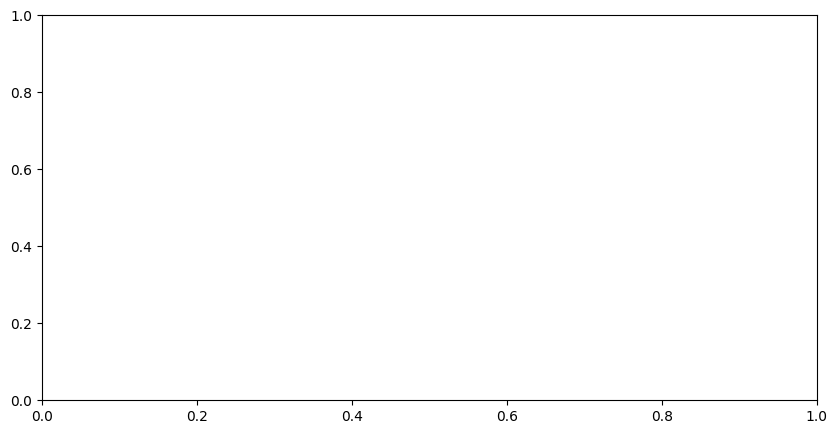

In [217]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
for i, client in enumerate(clients):
    plt.plot(
        epochs_range,
        accuracies[i],
        label=f"Client {client}" if client != 0 else "aggregate",
    )
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Each Client")
plt.show()

plt.figure(figsize=(10, 5))
for i, client in enumerate(clients):
    plt.plot(epochs_range, losses[i], label=f"Client {client}" if client != 0 else "aggregate")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss for Each Client")
plt.show()

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
# for i, client in enumerate(clients):
plt.plot(epochs_range, accuracies[0], label=f"Client {client}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Each Client")
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

model = models[0]
# Assuming you have a trained model named 'model'
# and input data 'X_test' and corresponding labels 'y_test'

# Select a sample image from the test set
# Select a sample image from the test set
sample_image = X_test[1]  # Adjust the index as needed
sample_label = y_test[1]

# Preprocess the sample image
sample_image = sample_image[np.newaxis, ...]  # Add batch dimension

# Initialize the model
# model = model_init()

# Create a model that outputs the activations of the first dense layer
layer_name = "dense_40"  # Name of the first dense layer in your model
activation_model = Model(
    inputs=model.inputs, outputs=model.get_layer(layer_name).output
)

# Get the activations of the first dense layer
activations = activation_model.predict(sample_image)

# Plot the sample image and the activation map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(sample_image[0], cmap="gray")  # Assuming grayscale image
ax1.set_title("Sample Image")
ax1.axis("off")

ax2.imshow(activations[0].reshape(2, 4), cmap="viridis", interpolation="nearest")
ax2.set_title("Activation Map")
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()